# ♻️ Trash Classification using Transfer Learning (MobileNetV2)

### 🧠 Built by: Shiv Sablok  
Welcome to this end-to-end deep learning project where we classify trash into different categories using powerful **Transfer Learning** with **MobileNetV2**.

---

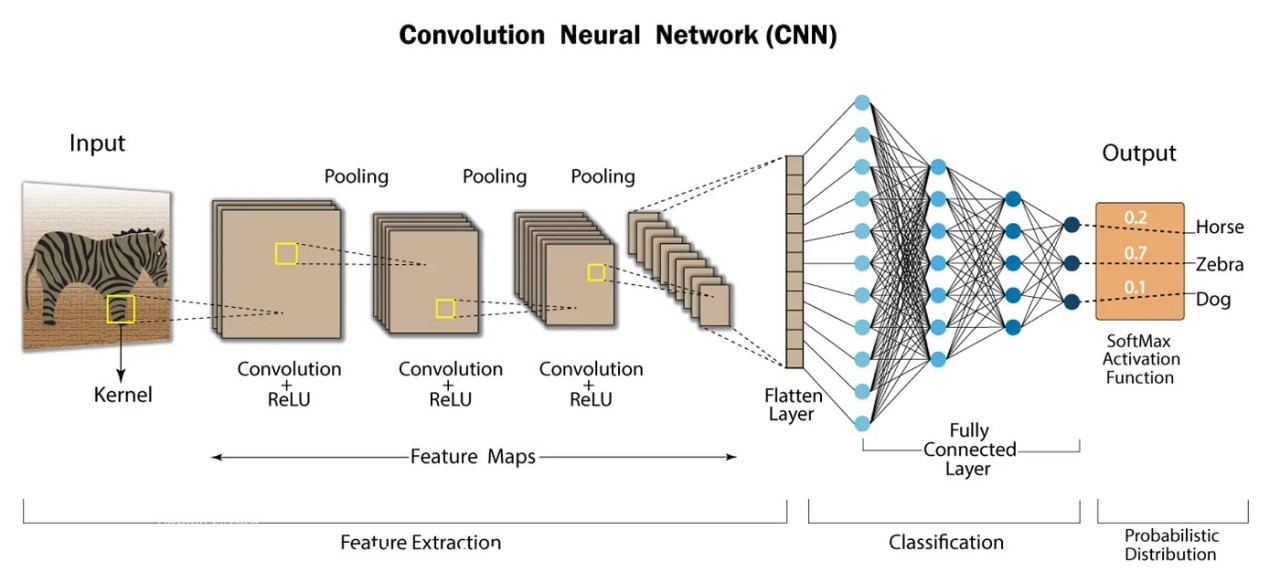


### Transfer Learning :
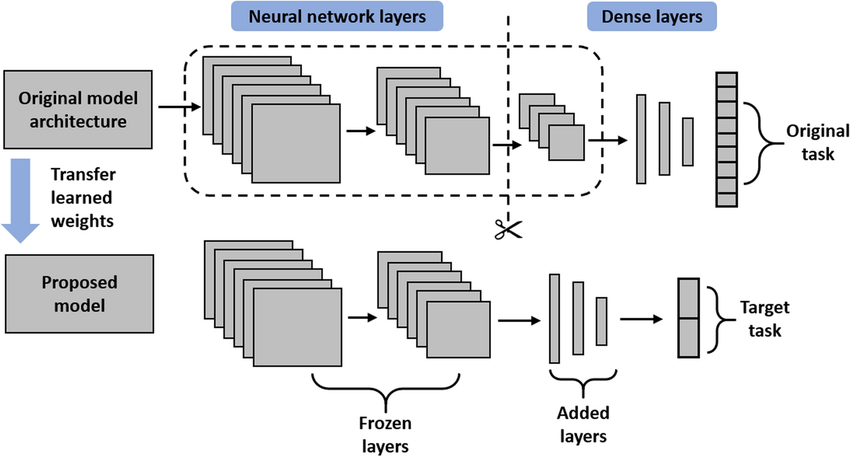

## 📌 Project Overview

Garbage classification is a critical step towards a cleaner and more sustainable environment. In this project, we use **Convolutional Neural Networks (CNNs)** with **pre-trained MobileNetV2** to classify images of trash into **6 distinct categories**.

This project demonstrates the full pipeline:
- 📁 **Loading and Exploring** a real-world image dataset
- 🧼 **Data Preprocessing** and Augmentation
- 🧠 **Model Building** using **MobileNetV2**
- 📉 **Training with Callbacks** (EarlyStopping & ModelCheckpoint)
- 📊 **Evaluation** using Accuracy and Loss Curves
- 📷 **Real-world Prediction** with custom image upload
- 🌐 Ready for **Flask Deployment**

---

## 🗂 Dataset Info

- Total Images: `2527`
- Categories (6):
  - `cardboard`
  - `glass`
  - `metal`
  - `paper`
  - `plastic`
  - `trash`
- Train Images: `2024`
- Validation Images: `503`
- Image Dimensions: `224 x 224 x 3`

---

## 🚀 Why Transfer Learning?

Training a CNN from scratch requires large datasets and computation. **Transfer Learning** helps us:
- Leverage pre-trained features from **ImageNet**
- Speed up training
- Achieve higher accuracy with fewer resources

We use **MobileNetV2** (lightweight + high performance) as our base model.

---

## 🛠 Tools & Libraries

- Python 🐍
- TensorFlow / Keras
- Matplotlib / Seaborn
- PIL for image handling
- Google Colab (for training & testing)

---

## 🏁 End Goal

- Train a high-performing trash classifier
- Predict custom real-world trash images
- Save and export the model for production
- (Optional) Deploy this model using Flask on the web

---
---

## Importing Libraries and Dataset

✅ 1. Importing Required Libraries & Unzipping the Dataset

In this section, we are going to import all the essential Python libraries required for building our Trash Classification model.

We’ll also unzip the **TrashNet** dataset, which contains categorized images of 6 waste types:
- Cardboard
- Glass
- Metal
- Paper
- Plastic
- Trash



In [ ]:
import tensorflow as tf
import os

In [ ]:
!unzip -q "trashnet.zip" -d dataset

## 📊 2. Exploratory Data Analysis (EDA)

Let’s explore the dataset to better understand its structure and balance.

We will:
- Count the number of images per class
- Visualize class distribution with bar plots
- Display a few sample images from each class
- Check image size and format using **PIL**


In [ ]:
data_dir = 'dataset/dataset-resized'

# Count images per class
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        print(f"{class_name}: {num_images} images")


paper: 594 images
trash: 137 images
cardboard: 403 images
plastic: 482 images
metal: 410 images
glass: 501 images


<BarContainer object of 6 artists>

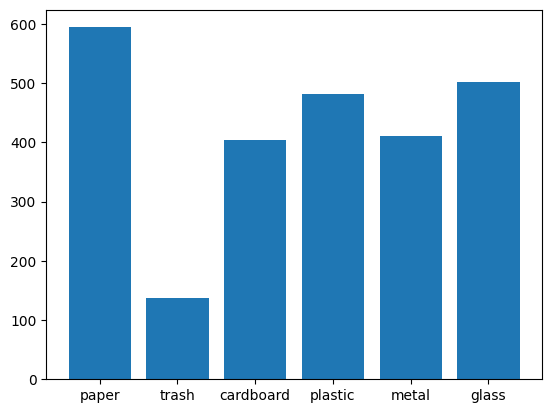

In [ ]:
import matplotlib.pyplot as plt
plt.bar(os.listdir(data_dir), [len(os.listdir(os.path.join(data_dir, class_name))) for class_name in os.listdir(data_dir)])

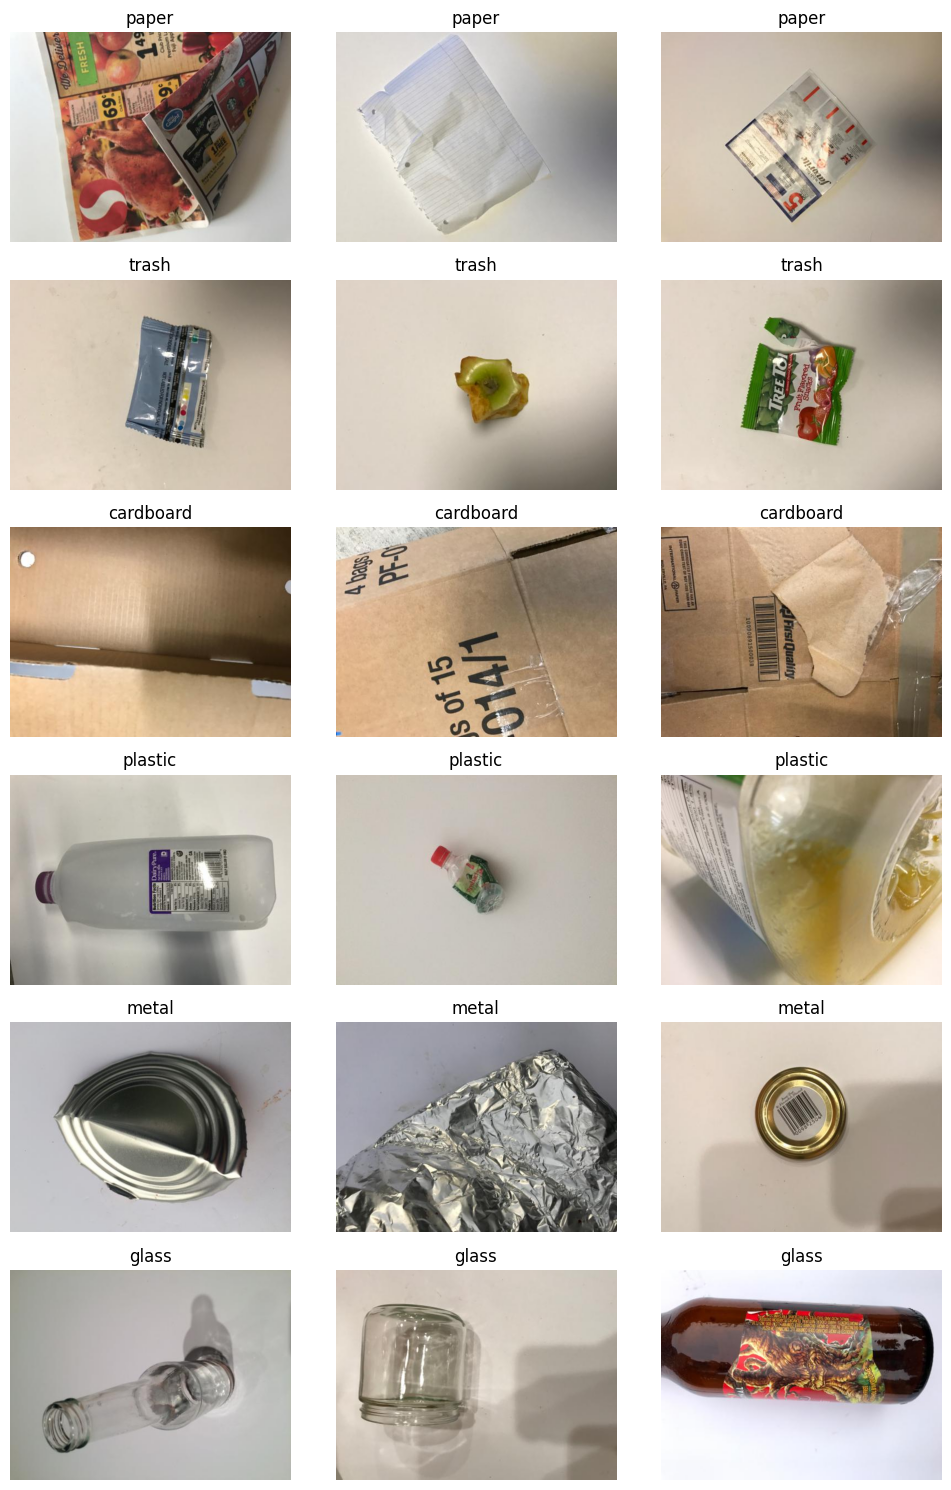

In [ ]:
import matplotlib.image as mpimg

class_names = os.listdir(data_dir)
plt.figure(figsize=(10,15))

for i, class_name in enumerate(class_names):
    img_paths = os.listdir(os.path.join(data_dir, class_name))[:3]  # first two images
    for j, img_file in enumerate(img_paths):
        img_path = os.path.join(data_dir, class_name, img_file)
        img = mpimg.imread(img_path)
        plt.subplot(len(class_names), 3, i*3 + j + 1)
        plt.title(class_name)
        plt.imshow(img)
        plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
from PIL import Image
from collections import Counter

image_sizes = []

# Traverse all images and collect their size
for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            with Image.open(img_path) as img:
                image_sizes.append(img.size)  # (width, height)
        except:
            print(f"Could not open image: {img_path}")

# Count unique sizes
size_counts = Counter(image_sizes)
print("Unique Image Sizes and their Counts:")
for size, count in size_counts.items():
    print(f"Size: {size}  -->  Count: {count}")


Unique Image Sizes and their Counts:
Size: (512, 384)  -->  Count: 2527


## 🧼 3. Data Preprocessing & Augmentation

Now we’ll prepare the data for model training. In this phase, we will:
- Use `ImageDataGenerator` to load images with real-time data augmentation
- Split the dataset into **training** and **validation** sets
- Apply augmentations like rotation, zoom, flip, etc.
- Visualize the distribution of training and validation images

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
batch_size = 32

# Augmenting only training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,         # randomly rotate up to 20 degrees
    width_shift_range=0.2,     # shift image width by 20%
    height_shift_range=0.2,    # shift image height by 20%
    shear_range=0.15,          # shearing
    zoom_range=0.2,            # zoom in/out
    horizontal_flip=True,      # flip images
    fill_mode='nearest',       # filling empty pixels
    validation_split=0.2       # 20% validation
)

# Validation data: no augmentation, only rescale
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Generators
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)


Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


In [ ]:
train_generator.class_indices


{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

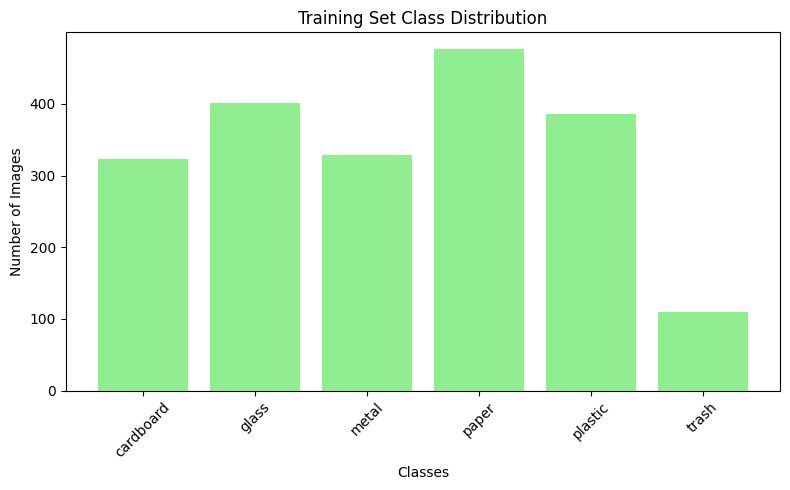

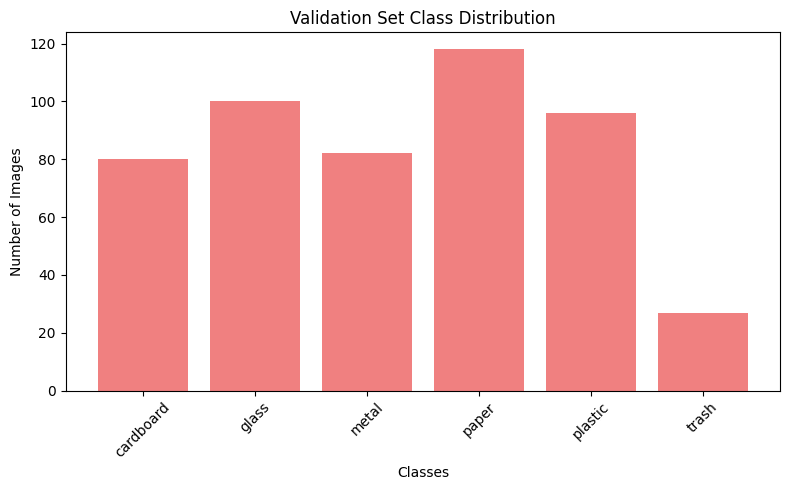

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get class names from the train generator
class_labels = train_generator.class_indices
class_names = list(class_labels.keys())

# Training set class counts
train_class_counts = np.bincount(train_generator.classes)

# Validation set class counts
val_class_counts = np.bincount(val_generator.classes)

# Plot 1: Training Set
plt.figure(figsize=(8, 5))
plt.bar(class_names, train_class_counts, color='lightgreen')
plt.title("Training Set Class Distribution")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 2: Validation Set
plt.figure(figsize=(8, 5))
plt.bar(class_names, val_class_counts, color='lightcoral')
plt.title("Validation Set Class Distribution")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 🧠 4. Transfer Learning with MobileNetV2 and Model Building & Training

We will now build our classification model using **Transfer Learning**. Specifically:
- Load **MobileNetV2** without its top layers
- Freeze the pre-trained base layers
- Add custom dense layers for our 6-class classification
- Compile the model with suitable optimizer and loss function

Let’s now train the model.

We will:
- Use **EarlyStopping** to halt training if validation performance stops improving
- Use **ModelCheckpoint** to save the best model
- Train the model and store training logs using `history` object


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load MobileNetV2 without top layers
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')

# Freeze the base model layers (so they don't train again)
base_model.trainable = False


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Add custom layers on top of the base MobileNetV2
from tensorflow.keras.layers import BatchNormalization

x = base_model.output                      # output of MobileNetV2
x = GlobalAveragePooling2D()(x)            # reduces the spatial dimensions to 1x1x1280
x = BatchNormalization()(x)
x = Dropout(0.3)(x)                        # dropout for regularization
x = Dense(256, activation='relu')(x)       # a dense hidden layer
x = Dropout(0.35)(x)
predictions = Dense(6, activation='softmax')(x)  # final output layer (6 classes)

# Define full model
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,592,582 (9.89 MB)

 Trainable params: 332,038 (1.27 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)


In [ ]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.2877 - loss: 2.1882

64/64 ━━━━━━━━━━━━━━━━━━━━ 43s 511ms/step - accuracy: 0.2889 - loss: 2.1841 - val_accuracy: 0.5646 - val_loss: 1.1601
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.5383 - loss: 1.3368

64/64 ━━━━━━━━━━━━━━━━━━━━ 25s 389ms/step - accuracy: 0.5386 - loss: 1.3357 - val_accuracy: 0.6561 - val_loss: 0.9227
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.5839 - loss: 1.2215

64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 391ms/step - accuracy: 0.5844 - loss: 1.2199 - val_accuracy: 0.6839 - val_loss: 0.8219
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.6488 - loss: 1.0074

64/64 ━━━━━━━━━━━━━━━━━━━━ 25s 386ms/step - accuracy: 0.6490 - loss: 1.0066 - val_accuracy: 0.7097 - val_loss: 0.7633
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.7020 - loss: 0.8271

64/64 ━━━━━━━━━━━━━━━━━━━━ 25s 388ms/step - accuracy: 0.7019 - loss: 0.8276 - val_accuracy: 0.7157 - val_loss: 0.7511
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.6967 - loss: 0.8120

64/64 ━━━━━━━━━━━━━━━━━━━━ 25s 390ms/step - accuracy: 0.6968 - loss: 0.8120 - val_accuracy: 0.7356 - val_loss: 0.7385
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.7129 - loss: 0.8105

64/64 ━━━━━━━━━━━━━━━━━━━━ 25s 388ms/step - accuracy: 0.7132 - loss: 0.8098 - val_accuracy: 0.7376 - val_loss: 0.7132
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.7260 - loss: 0.7699

64/64 ━━━━━━━━━━━━━━━━━━━━ 25s 385ms/step - accuracy: 0.7261 - loss: 0.7694 - val_accuracy: 0.7475 - val_loss: 0.6995
Epoch 9/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 24s 382ms/step - accuracy: 0.7546 - loss: 0.7189 - val_accuracy: 0.7435 - val_loss: 0.6911
Epoch 10/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.7701 - loss: 0.6683

64/64 ━━━━━━━━━━━━━━━━━━━━ 25s 390ms/step - accuracy: 0.7699 - loss: 0.6685 - val_accuracy: 0.7535 - val_loss: 0.6818
Epoch 11/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.7840 - loss: 0.5838

64/64 ━━━━━━━━━━━━━━━━━━━━ 25s 390ms/step - accuracy: 0.7839 - loss: 0.5844 - val_accuracy: 0.7594 - val_loss: 0.6789
Epoch 12/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 24s 382ms/step - accuracy: 0.7658 - loss: 0.6810 - val_accuracy: 0.7575 - val_loss: 0.6652
Epoch 13/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.7867 - loss: 0.5832

64/64 ━━━━━━━━━━━━━━━━━━━━ 25s 387ms/step - accuracy: 0.7867 - loss: 0.5831 - val_accuracy: 0.7674 - val_loss: 0.6450
Epoch 14/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 25s 386ms/step - accuracy: 0.7894 - loss: 0.5896 - val_accuracy: 0.7674 - val_loss: 0.6415
Epoch 15/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 25s 386ms/step - accuracy: 0.7973 - loss: 0.5629 - val_accuracy: 0.7634 - val_loss: 0.6342
Epoch 16/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.8008 - loss: 0.5499

64/64 ━━━━━━━━━━━━━━━━━━━━ 25s 384ms/step - accuracy: 0.8007 - loss: 0.5501 - val_accuracy: 0.7734 - val_loss: 0.6373
Epoch 17/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 25s 384ms/step - accuracy: 0.8066 - loss: 0.5304 - val_accuracy: 0.7734 - val_loss: 0.6438
Epoch 18/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 25s 384ms/step - accuracy: 0.7985 - loss: 0.5331 - val_accuracy: 0.7734 - val_loss: 0.6449
Epoch 19/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.8008 - loss: 0.5397

64/64 ━━━━━━━━━━━━━━━━━━━━ 25s 388ms/step - accuracy: 0.8008 - loss: 0.5394 - val_accuracy: 0.7773 - val_loss: 0.6377
Epoch 20/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 24s 381ms/step - accuracy: 0.8171 - loss: 0.5297 - val_accuracy: 0.7773 - val_loss: 0.6322


## 📈 5. Visualizing Accuracy and Loss

We will visualize the training process by plotting:
- Training vs Validation **Accuracy**
- Training vs Validation **Loss**

These plots will help us evaluate learning patterns and check for underfitting or overfitting.


In [ ]:
# Assuming `history` is the History object returned by model.fit()

train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]

train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

print(f"✅ Final Training Accuracy   : {train_acc:.4f}")
print(f"✅ Final Validation Accuracy : {val_acc:.4f}")
print(f"🔻 Final Training Loss       : {train_loss:.4f}")
print(f"🔻 Final Validation Loss     : {val_loss:.4f}")


✅ Final Training Accuracy   : 0.8211
✅ Final Validation Accuracy : 0.7773
🔻 Final Training Loss       : 0.5122
🔻 Final Validation Loss     : 0.6322


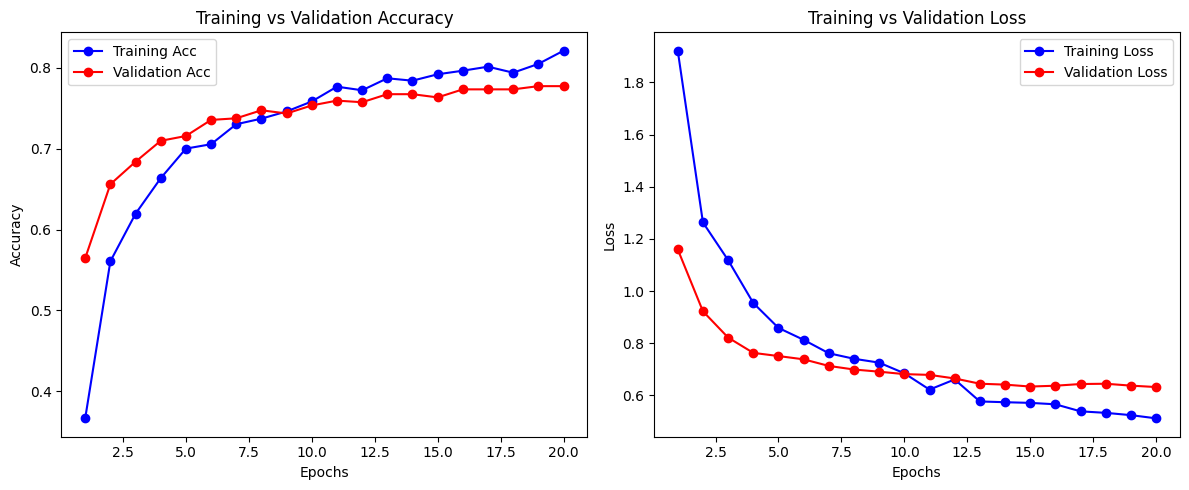

In [ ]:
import matplotlib.pyplot as plt

# Extract values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)

# Accuracy plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Acc')
plt.plot(epochs, val_acc, 'ro-', label='Validation Acc')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## 💾 6. Saving the Trained Model

After successful training, we’ll save our final model in `.h5` format.

This will allow us to reuse it during Flask deployment for real-time image classification.


In [ ]:
from google.colab import files
files.download('best_model.h5')
files.download('best_model_no_overfit.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 🌍 7. Model Evaluation and Real-World Image Testing

In the final phase, we will test our model on a real-world image (downloaded or captured).

We’ll:
- Load and preprocess the image
- Use the trained model to make a prediction
- Display the image with its predicted label and confidence score


In [15]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

def predict_trash_image(model_path, img_path):
    """
    Loads a model and image, then predicts the class of the image.

    Args:
        model_path (str): Path to .h5 Keras model
        img_path (str): Path to image (JPG/PNG)

    Returns:
        str: Predicted class
        float: Confidence score (0 to 1)
    """

    # Load model
    model = load_model(model_path)

    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Show image
    plt.imshow(img)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    # Prediction
    pred = model.predict(img_array)
    class_index = np.argmax(pred)
    confidence = np.max(pred)

    # Class labels — replace as per your dataset!
    class_labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

    predicted_class = class_labels[class_index]

    print(f"🧠 Predicted Class : {predicted_class}")
    print(f"🔍 Confidence      : {confidence*100:.2f}%")


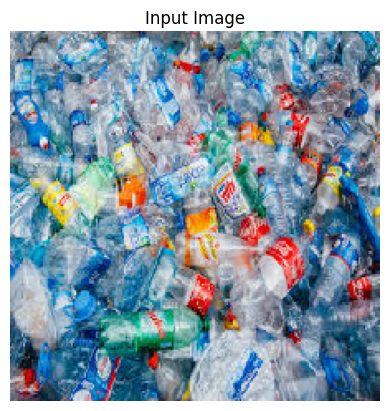

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
🧠 Predicted Class : plastic
🔍 Confidence      : 86.51%


In [16]:
predict_trash_image('best_model.h5', 'plastic.jpg')

In [17]:
predict_trash_image('best_model.h5', 'paper.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
🧠 Predicted Class : paper
🔍 Confidence      : 88.03%


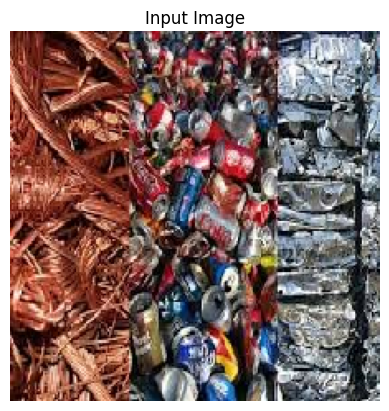

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
🧠 Predicted Class : metal
🔍 Confidence      : 77.02%


In [18]:
predict_trash_image('best_model.h5', 'metal.jpg')

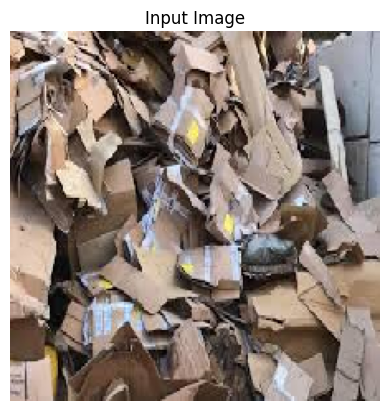

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
🧠 Predicted Class : paper
🔍 Confidence      : 83.46%


In [19]:
predict_trash_image('best_model.h5', 'cardboard.jpg')

In [20]:
predict_trash_image('best_model.h5', 'cardboard2.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
🧠 Predicted Class : cardboard
🔍 Confidence      : 99.58%


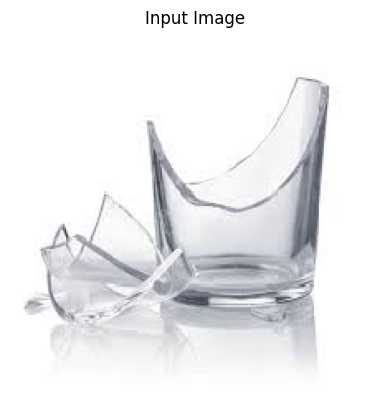

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
🧠 Predicted Class : glass
🔍 Confidence      : 29.57%


In [27]:
predict_trash_image('best_model.h5', 'glass.jpg')

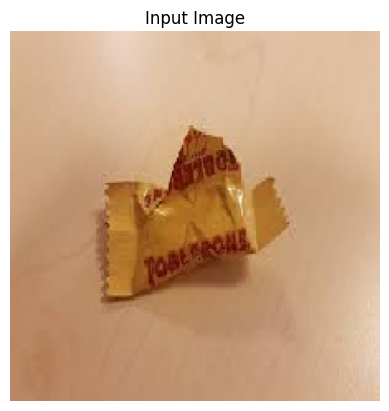

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
🧠 Predicted Class : trash
🔍 Confidence      : 92.63%


In [29]:
predict_trash_image('best_model.h5', 'tofee.jpg')


In [32]:
from google.colab import files
files.download('cardboard.jpg')
files.download('cardboard2.jpg')
files.download('glass.jpg')
files.download('tofee.jpg')
files.download('plastic.jpg')
files.download('paper.jpg')
files.download('metal.jpg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>